In [48]:

import os
import torch
import gc

gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()        
    torch.cuda.ipc_collect()


try:
    %run setup_paths
except:
    %run notebooks/setup_paths
    
os.getcwd()

'c:\\Projects\\saliency'

In [29]:
%run src/dataset

isrc = ImagenetSource("imagenet_samples", "*")
all_images = isrc.get_all_images()


(-0.5, 223.5, 223.5, -0.5)

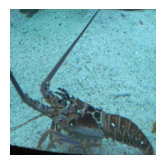

In [35]:
%run src/benchmark
image_name = "ILSVRC2012_val_00012455" ## lobster
image_info = all_images[image_name]
image_path = image_info.path
targetidx = image_info.target
img=Image.open(image_path)
img=img.resize((224,224))  
plt.subplot(1, 3, 1)
plt.imshow(img)
plt.axis('off')


In [37]:
%run src/benchmark
me = ModelEnv('resnet50')

inp = me.get_image(image_path)
logits = me.model(inp).cpu()
topidx = int(torch.argmax(logits))

print(topidx, targetidx)

C:\Users\zivhd\anaconda3\envs\mcmc\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\zivhd\anaconda3\envs\mcmc\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


123 123


In [38]:
sals_dict = {}

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.26it/s]


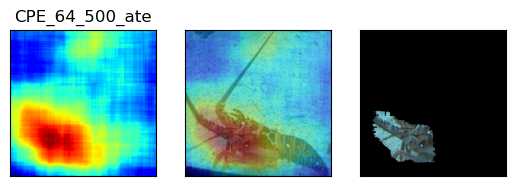

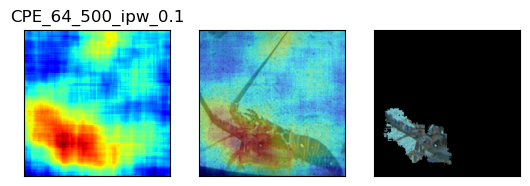

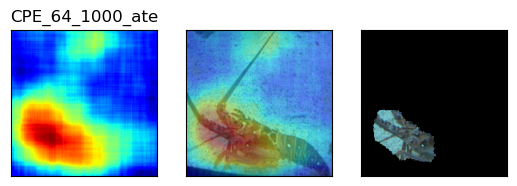

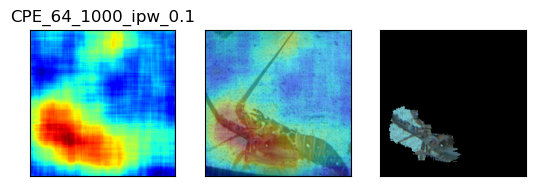

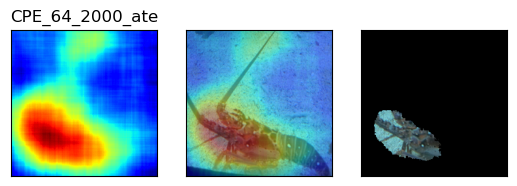

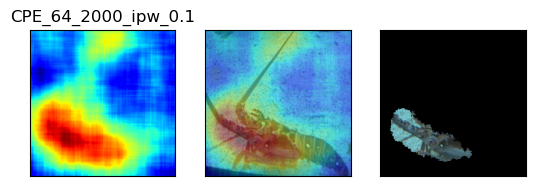

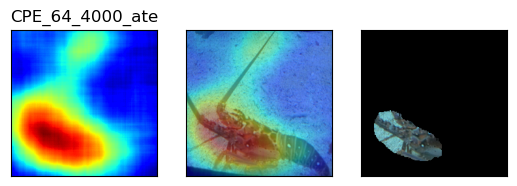

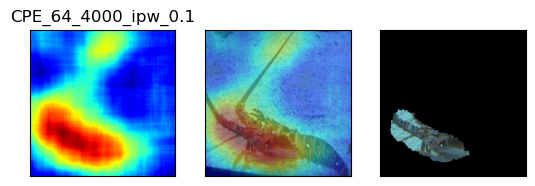

In [45]:
%run src/intutils
%run src/cpe

segsize=64
algo = IpwSalCreator(f"CPE_{segsize}", [500,1000,2000,4000], segsize=segsize, batch_size=32)
res = algo(me, inp, topidx)
show_sal_dict(res, img)
sals_dict.update(res)


In [46]:
#dir(algo)

In [61]:
#run src/adaptors
#import pytorch_grad_cam 
#dir(pytorch_grad_cam)

ddd = [1,2,3]
import random
random.shuffle(ddd)
ddd

[2, 3, 1]

In [65]:
ee= 1000
f"{ee:x}"

'3e8'